## 1 : Imports et Configuration

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning - Outils
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
PROCESSOR_PATH = "processors/"
MODEL_PATH = "models/"
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"📅 Démarrage : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📅 Démarrage : 2025-11-19 17:42:57


## 2 : Chargement des Données

In [2]:
print("🔄 Chargement des données...")

# Charger les données brutes (X, y)
with open(os.path.join(PROCESSOR_PATH, "data_for_modeling.pkl"), "rb") as f:
    data = pickle.load(f)
    X = data["X"]
    y = data["y"]
    numeric_cols = data["numeric_cols"]

# Charger le LabelEncoder pour l'affichage
with open(os.path.join(PROCESSOR_PATH, "label_encoder_target.pkl"), "rb") as f:
    le_target = pickle.load(f)

print(f"✅ Données chargées : {X.shape}")
print(f"🎯 Cibles : {len(le_target.classes_)} classes")

🔄 Chargement des données...
✅ Données chargées : (398911, 17)
🎯 Cibles : 7 classes


## 3 : Fonction d'Optimisation du Split

In [3]:
def find_best_split(X, y, model, num_cols):
    """Cherche le meilleur ratio train/test avec un modèle rapide (LGBM)"""
    print("🚀 Recherche du meilleur ratio Train/Test...")
    results = []
    
    # On utilise LightGBM car il est très rapide pour cette recherche
    for size in [0.1,0.15, 0.20, 0.25, 0.30]:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=size, random_state=42, stratify=y)
        
        scaler = RobustScaler()
        X_tr_sc = X_tr.copy()
        X_te_sc = X_te.copy()
        X_tr_sc[num_cols] = scaler.fit_transform(X_tr[num_cols])
        X_te_sc[num_cols] = scaler.transform(X_te[num_cols])
        
        model.fit(X_tr_sc, y_tr)
        score = f1_score(y_te, model.predict(X_te_sc), average='weighted')
        results.append((size, score))
        print(f"   👉 Split {int(size*100)}% : F1 = {score:.4f}")
    
    best_size = max(results, key=lambda x: x[1])[0]
    print(f"🏆 Meilleur Split retenu : {int(best_size*100)}%")
    return best_size

# Utilisation d'un modèle rapide pour décider du split
quick_model = LGBMClassifier(n_estimators=50, random_state=42, verbose=-1)
BEST_TEST_SIZE = find_best_split(X, y, quick_model, numeric_cols)

🚀 Recherche du meilleur ratio Train/Test...
   👉 Split 10% : F1 = 0.8525
   👉 Split 15% : F1 = 0.8539
   👉 Split 20% : F1 = 0.8534
   👉 Split 25% : F1 = 0.8534
   👉 Split 30% : F1 = 0.8523
🏆 Meilleur Split retenu : 15%


## Préparation Finale des Données

In [4]:
print(f"🛠️ Préparation des données finales (Test={BEST_TEST_SIZE})...")

# 1. Split Final
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=BEST_TEST_SIZE, random_state=42, stratify=y
)

# 2. Scaling Final
final_scaler = RobustScaler()
X_train[numeric_cols] = final_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = final_scaler.transform(X_test[numeric_cols])

# Sauvegarde du scaler tout de suite
with open(os.path.join(PROCESSOR_PATH, "scaler_final.pkl"), "wb") as f:
    pickle.dump(final_scaler, f)

print("✅ Données prêtes et Scaler sauvegardé.")

🛠️ Préparation des données finales (Test=0.15)...
✅ Données prêtes et Scaler sauvegardé.


## Définition des Modèles (Bagging & Boosting)

In [5]:
# Dictionnaire des modèles
models = {
    "RandomForest (Bagging)": RandomForestClassifier(
        n_estimators=150,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42
    ),
    
    "LightGBM": LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
    
    "CatBoost": CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=6,
        verbose=0, # Silencieux
        random_state=42,
        allow_writing_files=False
    )
}

##  Entraînement et Comparaison

🏋️‍♂️ Démarrage de l'entraînement (Évaluation : ROC-AUC)...

>> Entraînement de RandomForest (Bagging)...
   ✅ Terminé en 48.5s | ROC-AUC: 0.9781

>> Entraînement de XGBoost...
   ✅ Terminé en 42.7s | ROC-AUC: 0.9823

>> Entraînement de LightGBM...
   ✅ Terminé en 26.9s | ROC-AUC: 0.9799

>> Entraînement de CatBoost...
   ✅ Terminé en 29.6s | ROC-AUC: 0.9800


,Modèle,Accuracy,F1-Score,ROC-AUC,Temps (s)
1,XGBoost,0.862894,0.856289,0.982263,42.680735
3,CatBoost,0.856026,0.848474,0.979982,29.591351
2,LightGBM,0.833915,0.843667,0.979872,26.936657
0,RandomForest (Bagging),0.842355,0.844306,0.978100,48.477592


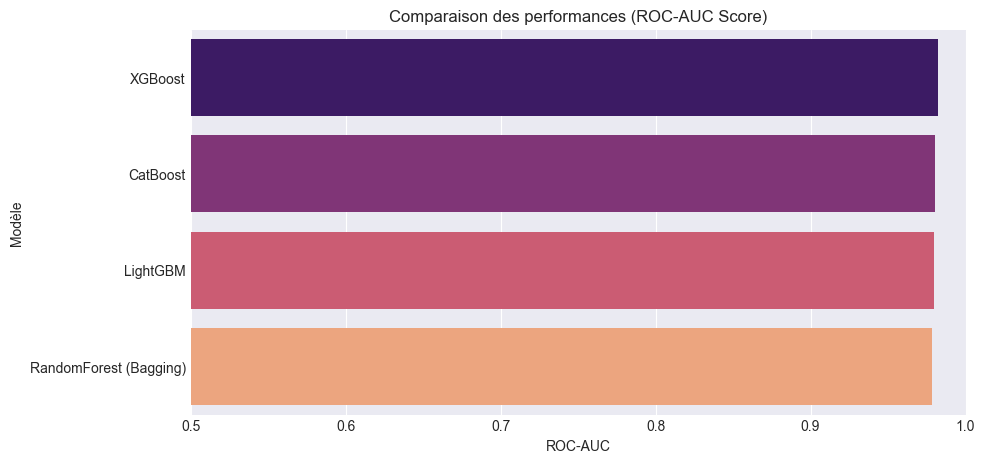

In [6]:
from sklearn.metrics import roc_auc_score

results_df = []

print("🏋️‍♂️ Démarrage de l'entraînement (Évaluation : ROC-AUC)...")

trained_models = {}

for name, model in models.items():
    start = time.time()
    print(f"\n>> Entraînement de {name}...")
    
    # 1. Entraînement
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # 2. Prédictions
    # Pour le F1/Accuracy, on a besoin des classes (0, 1, 2...)
    y_pred = model.predict(X_test)
    
    # ⚠️ CHANGEMENT CLÉ : Pour le ROC-AUC, on a besoin des PROBABILITÉS
    y_proba = model.predict_proba(X_test)
    
    # 3. Calcul des Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ⚠️ Calcul du ROC-AUC Multi-classes
    # multi_class='ovr' : Compare chaque classe contre toutes les autres
    # average='weighted': Tient compte du déséquilibre de vos classes
    try:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    except Exception as e:
        print(f"   ⚠️ Erreur ROC-AUC pour {name}: {e}")
        roc_auc = 0
        
    elapsed = time.time() - start
    
    results_df.append({
        "Modèle": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC-AUC": roc_auc, # On ajoute la nouvelle métrique
        "Temps (s)": elapsed
    })
    
    print(f"   ✅ Terminé en {elapsed:.1f}s | ROC-AUC: {roc_auc:.4f}")

# Affichage du tableau comparatif (Trié par ROC-AUC cette fois)
df_scores = pd.DataFrame(results_df).sort_values(by="ROC-AUC", ascending=False)
display(df_scores)

# Graphique basé sur le ROC-AUC
plt.figure(figsize=(10, 5))
sns.barplot(x="ROC-AUC", y="Modèle", data=df_scores, palette="magma") # Changement de palette pour varier
plt.title("Comparaison des performances (ROC-AUC Score)")
plt.xlim(0.5, 1) # Le ROC-AUC est entre 0.5 (hasard) et 1.0 (parfait)
plt.show()

 ## Le Stacking 

In [8]:
print("\n🏗️ Construction du modèle Stacking (Optimisé pour ROC-AUC)...")

# 1. Configuration des modèles de base
# Note : Pour le stacking avec ROC-AUC, il est préférable que les modèles de base soient calibrés,
# mais XGBoost/LGBM/CatBoost le sont généralement assez bien naturellement.
estimators = [
    ('rf', models['RandomForest (Bagging)']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM']),
    ('cat', models['CatBoost'])
]

# 2. Le Méta-Modèle
# On garde la Régression Logistique, c'est robuste et efficace pour le stacking.
final_estimator = LogisticRegression(max_iter=1000)

# 3. Création du Stacking Classifier
# stack_method='predict_proba' est crucial ici !
# Cela dit au Stacking d'utiliser les PROBABILITÉS des modèles de base comme entrée pour le méta-modèle,
# ce qui est beaucoup plus riche en information que les simples prédictions de classe.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    cv=3,
    stack_method='predict_proba' # IMPORTANT pour maximiser le ROC-AUC
)

# 4. Entraînement
print("⏳ Entraînement du Stacking en cours...")
stack_start = time.time()
stacking_model.fit(X_train, y_train)
stack_time = time.time() - stack_start

# 5. Évaluation (Probabilités pour ROC-AUC)
y_proba_stack = stacking_model.predict_proba(X_test)

try:
    stack_roc_auc = roc_auc_score(y_test, y_proba_stack, multi_class='ovr', average='weighted')
except Exception as e:
    print(f"⚠️ Erreur calcul ROC-AUC Stacking: {e}")
    stack_roc_auc = 0

print(f"✅ Stacking terminé en {stack_time:.1f}s")
print(f"🏆 ROC-AUC Stacking : {stack_roc_auc:.4f}")

# 6. Comparaison
# On compare avec le meilleur ROC-AUC individuel trouvé précédemment
best_single_roc = df_scores.iloc[0]['ROC-AUC']
best_single_name = df_scores.iloc[0]['Modèle']
gain = stack_roc_auc - best_single_roc

if gain > 0:
    print(f"🚀 Le Stacking a amélioré le ROC-AUC de +{gain:.4f} par rapport à {best_single_name}!")
else:
    print(f"⚠️ Le Stacking ({stack_roc_auc:.4f}) n'a pas battu {best_single_name} ({best_single_roc:.4f}).")


🏗️ Construction du modèle Stacking (Optimisé pour ROC-AUC)...
⏳ Entraînement du Stacking en cours...
✅ Stacking terminé en 318.7s
🏆 ROC-AUC Stacking : 0.9809
⚠️ Le Stacking (0.9809) n'a pas battu XGBoost (0.9823).


## 5. 🔧 Phase 2: Fine-Tuning avec RandomizedSearchCV

### 5.1 Définition des Hyperparamètres à Tester

In [9]:
from sklearn.model_selection import RandomizedSearchCV
import time

# 1. Définition des grilles de recherche (Hyperparameters Grid)
def get_param_distributions():
    """
    Définit les distributions de paramètres pour RandomizedSearchCV
    """
    param_distributions = {
        'RandomForest': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [1, 3, 5]
        },
        
        'LightGBM': {
            'n_estimators': [100, 200, 300],
            'max_depth': [-1, 10, 20], # -1 = no limit
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [20, 31, 50, 100], # Important pour LGBM
            'min_child_samples': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        },
        
        'CatBoost': {
            'iterations': [100, 200, 300, 500],
            'depth': [4, 6, 8, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'border_count': [32, 64, 128],
            'bagging_temperature': [0, 1],
            'random_strength': [1, 2, 5]
        }
    }
    
    return param_distributions

print("✅ Grilles d'hyperparamètres chargées.")

✅ Grilles d'hyperparamètres chargées.


In [10]:
def tune_model(model, param_dist, X_train, y_train, n_iter=20, cv=3):
    """
    Exécute RandomizedSearchCV pour un modèle donné.
    """
    print(f"\n🔍 Tuning en cours pour : {model.__class__.__name__}...")
    start_time = time.time()
    
    # Configuration de la recherche
    # scoring='roc_auc_ovr_weighted' est idéal pour le multi-classe déséquilibré
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,          # Nombre de combinaisons à tester
        scoring='roc_auc_ovr_weighted', # Métrique à optimiser
        cv=cv,                  # Validation croisée (3 plis)
        verbose=1,
        random_state=42,
        n_jobs=-1               # Utilise tous les cœurs du CPU
    )
    
    # Lancement de la recherche
    search.fit(X_train, y_train)
    
    elapsed = time.time() - start_time
    print(f"✅ Tuning terminé en {elapsed:.1f}s")
    print(f"🏆 Meilleur score ROC-AUC : {search.best_score_:.4f}")
    print(f"🔧 Meilleurs paramètres : {search.best_params_}")
    
    return search.best_estimator_, search.best_params_, search.best_score_

In [ ]:
# 1. Initialisation des modèles de base (sans paramètres, sauf pour le silence/gpu)
base_models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, allow_writing_files=False, random_state=42)
}

# Récupération des grilles
params_grid = get_param_distributions()

# Dictionnaires pour stocker les résultats
tuned_models = {}
best_params_history = {}
tuning_results = []

print("="*80)
print(f"DÉMARRAGE DU FINE-TUNING SUR {len(base_models)} MODÈLES")
print("="*80)

# 2. Boucle d'optimisation
for name, model in base_models.items():
    # Lancer le tuning
    best_model, best_params, best_score = tune_model(
        model, 
        params_grid[name], 
        X_train, 
        y_train, 
        n_iter=15,  # 15 tests par modèle (ajustable selon votre temps/puissance)
        cv=3
    )
    
    # Stockage
    tuned_models[name] = best_model
    best_params_history[name] = best_params
    
    tuning_results.append({
        'Modèle': name,
        'Best ROC-AUC (CV)': best_score,
        'Best Params': str(best_params)
    })

# 3. Affichage du résumé
print("\n" + "="*80)
print("RÉSULTATS DU FINE-TUNING")
print("="*80)
df_tuning = pd.DataFrame(tuning_results).sort_values(by='Best ROC-AUC (CV)', ascending=False)
display(df_tuning)

DÉMARRAGE DU FINE-TUNING SUR 4 MODÈLES

🔍 Tuning en cours pour : RandomForestClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
print("\n🧪 Évaluation finale sur le Test Set...")
final_results = []

for name, model in tuned_models.items():
    # Prédictions (Probabilités pour ROC-AUC)
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    # Scores
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    
    final_results.append({
        'Modèle': name,
        'ROC-AUC Test': auc,
        'F1-Score Test': f1,
        'Accuracy Test': acc
    })

df_final_scores = pd.DataFrame(final_results).sort_values(by='ROC-AUC Test', ascending=False)
display(df_final_scores)

# Graphique comparatif
plt.figure(figsize=(10, 6))
sns.barplot(x='ROC-AUC Test', y='Modèle', data=df_final_scores, palette='magma')
plt.title('Performance des modèles après Fine-Tuning')
plt.xlim(0.5, 1.0)
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import joblib
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("🏗️ CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE STACKING")
print("="*80)

# 1. Définition des modèles de base (Base Learners)
# On utilise les modèles optimisés (tuned_models) que vous avez déjà entraînés
estimators = [
    ('rf_tuned', tuned_models['RandomForest']),
    ('xgb_tuned', tuned_models['XGBoost']),
    ('lgbm_tuned', tuned_models['LightGBM']),
    ('cat_tuned', tuned_models['CatBoost'])
]

# 2. Définition du méta-modèle (Final Estimator)
# La régression logistique est le choix standard et robuste pour le stacking
final_estimator = LogisticRegression(max_iter=2000, random_state=42)

# 3. Création du StackingClassifier
# stack_method='predict_proba' est essentiel pour maximiser le ROC-AUC :
# le méta-modèle recevra les probabilités de chaque classe, pas juste la classe finale.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=3,                            # Validation croisée interne pour éviter l'overfitting
    stack_method='predict_proba',    # Utilise les probabilités comme features pour le méta-modèle
    n_jobs=-1,                       # Parallélisation
    passthrough=False                # False = Le méta-modèle ne voit QUE les prédictions des bases, pas les features originales
)

# 4. Entraînement du Stacking
print("⏳ Entraînement du Stacking en cours (cela peut prendre du temps)...")
start_time = time.time()
stacking_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"✅ Entraînement terminé en {elapsed_time:.1f} secondes.")

# 5. Évaluation du Stacking
print("\n🧪 Évaluation du Stacking sur le Test Set...")

# Prédictions
y_pred_stack = stacking_model.predict(X_test)
y_prob_stack = stacking_model.predict_proba(X_test)

# Calcul des métriques
stack_acc = accuracy_score(y_test, y_pred_stack)
stack_f1 = f1_score(y_test, y_pred_stack, average='weighted')
try:
    stack_auc = roc_auc_score(y_test, y_prob_stack, multi_class='ovr', average='weighted')
except Exception as e:
    print(f"⚠️ Erreur calcul ROC-AUC Stacking: {e}")
    stack_auc = 0.0

print(f"📊 Performances du Stacking :")
print(f"   • Accuracy : {stack_acc:.4f}")
print(f"   • F1-Score : {stack_f1:.4f}")
print(f"   • ROC-AUC  : {stack_auc:.4f}")

# 6. Comparaison avec le meilleur modèle individuel
# On récupère le meilleur score individuel depuis votre DataFrame précédent (df_final_scores)
best_single_model_name = df_final_scores.iloc[0]['Modèle']
best_single_model_auc = df_final_scores.iloc[0]['ROC-AUC Test']

gain = stack_auc - best_single_model_auc

print("\n🔍 Comparaison Stacking vs Meilleur Modèle Individuel :")
print(f"   • Meilleur individuel ({best_single_model_name}) : {best_single_model_auc:.4f}")
print(f"   • Stacking (Ensemble)                         : {stack_auc:.4f}")

if gain > 0:
    print(f"🚀 RÉSULTAT : Le Stacking a amélioré la performance de +{gain:.5f} !")
elif gain == 0:
    print(f"⚖️ RÉSULTAT : Performance identique.")
else:
    print(f"📉 RÉSULTAT : Le Stacking est légèrement moins bon ({gain:.5f}).")
    print("   (Cela arrive parfois si le méta-modèle overfit ou si un modèle domine largement les autres)")

# 7. Sauvegarde du Stacking
print("\n💾 Sauvegarde du modèle Stacking...")
# On utilise le même dossier que pour les autres modèles tunés
SAVE_DIR = os.path.join(MODEL_PATH, "all_tuned_models_v1") 
os.makedirs(SAVE_DIR, exist_ok=True)

stack_filename = "Stacking_Classifier_Tuned.pkl"
stack_path = os.path.join(SAVE_DIR, stack_filename)
joblib.dump(stacking_model, stack_path)
print(f"✅ Modèle Stacking sauvegardé dans : {stack_path}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Liste pour accumuler toutes les données
comparison_data = []

# ==========================================
# 1. MODÈLES INDIVIDUELS (BASELINE)
# ==========================================
# On suppose que 'df_scores' contient les résultats de la toute première étape
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': f"{row['Modèle']}",
            'Version': '1. Baseline (Sans Tuning)',
            'Accuracy': row.get('Accuracy', 0),
            'F1-Score': row.get('F1-Score', 0),
            'ROC-AUC': row.get('ROC-AUC', 0),
            'Temps (s)': row.get('Temps (s)', 0)
        })

# ==========================================
# 2. STACKING (BASELINE)
# ==========================================
# Si vous avez sauvegardé les scores du premier stacking
# (Remplacez les noms de variables si nécessaire)
if 'stack_base_auc' in locals():
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking (Baseline)',
        'Accuracy': stack_base_acc,
        'F1-Score': stack_base_f1,
        'ROC-AUC': stack_base_auc,
        'Temps (s)': stack_base_time if 'stack_base_time' in locals() else 0
    })

# ==========================================
# 3. MODÈLES INDIVIDUELS (TUNED)
# ==========================================
# On suppose que 'df_final_scores' contient les résultats après RandomizedSearchCV
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': f"{row['Modèle']}",
            'Version': '3. Tuned (Optimisé)',
            'Accuracy': row.get('Accuracy Test', 0),
            'F1-Score': row.get('F1-Score Test', 0),
            'ROC-AUC': row.get('ROC-AUC Test', 0),
            'Temps (s)': 0
        })

# ==========================================
# 4. STACKING (TUNED)
# ==========================================
# Le dernier stacking que vous venez de faire
if 'stack_auc' in locals(): # ou stack_tuned_auc
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking (Tuned)',
        'Accuracy': stack_acc,      # ou stack_tuned_acc
        'F1-Score': stack_f1,       # ou stack_tuned_f1
        'ROC-AUC': stack_auc,       # ou stack_tuned_auc
        'Temps (s)': stack_time if 'stack_time' in locals() else 0
    })

# --- Création du DataFrame ---
df_global_comparison = pd.DataFrame(comparison_data)

# Tri par ROC-AUC pour le classement
df_global_comparison = df_global_comparison.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

# --- Affichage du Tableau ---
print(f"\n{'='*80}")
print("🏆 CLASSEMNT FINAL : DU BASELINE AU STACKING TUNED")
print(f"{'='*80}\n")

# Style avec dégradé de couleurs
styled_global = df_global_comparison.style.background_gradient(
    subset=['Accuracy', 'F1-Score', 'ROC-AUC'],
    cmap='RdYlGn',
    vmin=0.6, # Ajustez selon vos scores min
    vmax=1.0
).format({
    'Accuracy': '{:.4f}',
    'F1-Score': '{:.4f}',
    'ROC-AUC': '{:.4f}',
    'Temps (s)': '{:.1f}'
})

display(styled_global)

# --- Visualisation Graphique ---
plt.figure(figsize=(15, 9))

# Graphique en barres
# 'hue' permet de colorer selon la version (Baseline vs Tuned vs Stacking)
sns.barplot(
    data=df_global_comparison,
    y='Modèle',
    x='ROC-AUC',
    hue='Version', 
    palette='turbo', # Une palette très contrastée pour bien voir les 4 groupes
    edgecolor='black'
)

plt.title('Comparaison Ultime des Performances (ROC-AUC)', fontsize=16, fontweight='bold')
plt.xlabel('Score ROC-AUC', fontsize=12)
plt.ylabel('Algorithme', fontsize=12)
plt.xlim(0.6, 1.0) # Zoom sur la zone pertinente
plt.legend(title='Stade du Modèle', loc='lower right', bbox_to_anchor=(1, 0))
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# --- Conclusion Automatique ---
best = df_global_comparison.iloc[0]
print(f"\n🌟 CONCLUSION :")
print(f"Le modèle le plus performant est : {best['Modèle']} ({best['Version']})")
print(f"Avec un ROC-AUC de {best['ROC-AUC']:.4f}")

# Sauvegarde
save_path = os.path.join("models/", "GLOBAL_MODEL_LEADERBOARD.csv")
df_global_comparison.to_csv(save_path, index=False)
print(f"📁 Tableau de résultats sauvegardé : {save_path}")